# Experiment: Calibration

The goal here is to demonstrate a method of _calibrating_ zero-noise extrapolation. For a set of clasically simulable circuits (Clifford circuits in this case), we find the best combination of (noise factors, extrapolation function) for each (circuit area, error) point. This "phase diagram" can be used as a reference point for users who are too lazy to calibrate ZNE for their own circuits, but preferably, this framework can be adapted for different kinds of circuits or devices with different noise models.

Currently, we have a basic skeleton for this calibration. Specifically, we find the best extrapolation function for each (circuit area, error) point for a single Clifford circuit. We still need to (a) average over many circuits to generate enough statistical power and (b) test different noise factors. The latter requires us to have a system for sampling multiple partially folded circuits at noise factors that are not $1, 3, ..., 2n+1$.

In [1]:
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer.noise import depolarizing_error, NoiseModel
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import BackendEstimator

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_circ_area(qc, two_qubit_depth = True) -> int:
    """Returns the circuit area of the given circuit"""
    # defining circuit area by depth (after transpilation) * num_qubits
    # Default to two-qubit (2Q) depth, since 2Q errors are an order of magnitude larger than 1Q errors
    qc = transpile(qc, basis_gates=['x','sx','cx','rz']) # keeping this step to ensure transpilation
    if two_qubit_depth:
        depth = qc.depth(lambda x: x[0].num_qubits == 2)
    else:
        depth = qc.depth()
    num_qubits = qc.num_qubits()
    
    return depth*num_qubits

In [3]:
# This is to create the noise model with a single noise parameter. This can be changed as required

def create_depol_backend(p_depol: float):
    noisemodel = NoiseModel()
    err2 = depolarizing_error(p_depol,2) # error only on CNOT gates
    #err2 = err1.tensor(err1) # this is not really the case in real device, but this for now allows a single error parameter p_depol
    
    #noisemodel.add_all_qubit_quantum_error(err1,['x','sx'])
    noisemodel.add_all_qubit_quantum_error(err2,['cx'])
    
    backend = AerSimulator(noise_model=noisemodel)
    
    return backend

In [4]:
def create_clifford_circuit(qc):
    '''returns a clifford circuit similar in structure with qc'''
    # Replaces sx -> x
    # Replaces rz(angle) -> rz(pi)
    
    # first transpile the circuit to ensure we don't get other gates
    qc = transpile(qc, basis_gates=['x','sx','cx','rz'])
    
    # create dag from circuit
    qc_dag = circuit_to_dag(qc)
    
    # replace 'sx' and 'rz' appropriately
    for node in qc_dag.op_nodes():
        if node.op.name == 'sx':
            replacement = QuantumCircuit(1)
            replacement.x(0)
            qc_dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
        if node.op.name == 'rz':
            replacement = QuantumCircuit(1)
            replacement.rz(np.pi,0)
            qc_dag.substitute_node_with_dag(node, circuit_to_dag(replacement))
    
    # create updated circuit from dag
    circ = dag_to_circuit(qc_dag)
    
    return circ

In [5]:
def get_zne_expval(circ, obs: str, extrapolator, backend, noise_factors = [1,3,5,7], amplifier=LocalFoldingAmplifier(gates_to_fold=2), shots:int=2000) -> float:
    """Returns the results from zne experiments"""
    observable = SparsePauliOp(obs)
    
    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)
    
    zne_strategy = ZNEStrategy(
        noise_factors=noise_factors, 
        noise_amplifier=amplifier,
        extrapolator=extrapolator
    )
    
    job = estimator.run(circ, observable, shots=shots, zne_strategy=zne_strategy)
    result = job.result()
    
    return result

In [6]:
def create_trotter_circuit(num_qubits: int, params: list, trotter_steps: int):
    # creates a particular type of trotter circuit
    # params[0] is for Rx, params[1] is for Rz -> for now same for each layer
    
    trotter_layer = QuantumCircuit(num_qubits)
    trotter_layer.rx(params[0], range(num_qubits))
    
    # a single trotter layer
    for i in range(0,num_qubits,2):
        trotter_layer.cx(i,i+1)
        trotter_layer.rz(params[1], i+1)
        trotter_layer.cx(i,i+1)
    
    for i in range(1,num_qubits-1,2):
        trotter_layer.cx(i,i+1)
        trotter_layer.rz(params[1], i+1)
        trotter_layer.cx(i,i+1)
    
    # full trotter circuit
    trotter_circuit = QuantumCircuit(num_qubits)
    for i in range(trotter_steps):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    
    return trotter_circuit

In [7]:
def get_expval(circ, obs: str, shots:int=2000, backend=AerSimulator()):
    """Returns the expval for the given circuit and observable"""
    observable = SparsePauliOp(obs)
    estimator = BackendEstimator(backend=backend)
    
    job = estimator.run(circ, observable, shots=shots)
    result = job.result()
    
    return result

### for depolarization noise model

In [8]:
nqubits = 2
params = [0.1,0.2]
trot_step = 5

In [12]:
amplifiers = [LocalFoldingAmplifier(gates_to_fold=2)] # can also add global folding or remove only CNOT folding
extrapolators = [1,2,3] # takes the degree, currently 1 = linear, 2 = quadratic, 3 = cubic, 4 = quartic -> uses only PolynomialExtrapolator. This can be made to add others as well

num_qubits = range(2,11,2)
errors = np.linspace(0.001, 0.02, 10) # CNOT errors ranging from 0.001-0.02
best_extrapolator = {}
params = [0.1,0.2] # change this as necessary
trotter_steps = 4 # for experiment
shots=5000

for nqubits in num_qubits:
    print(f'Starting num_qubits {nqubits}')
    best_extrapolator[nqubits] = {}
    obs = 'Z'*nqubits
    for trot_step in range(1,trotter_steps+1):
        best_extrapolator[nqubits][trot_step] = {}
        trot_circ = create_trotter_circuit(nqubits,params,trot_step) # the original circuit
        
        # create the clifford version of the circuit
        trot_circ_clifford = create_clifford_circuit(trot_circ)
        clifford_result = get_expval(trot_circ_clifford, obs, shots=shots)
        clifford_expval = clifford_result.values[0] # ideal expval of the clifford circuit
        
        for p_depol in errors:
            best_extrapolator[nqubits][trot_step][p_depol] = 0 # 0 is not a valid degree, just a placeholder initially
            backend = create_depol_backend(p_depol)
            diff_expval = np.inf # initially the difference between ideal and noisy expval is set to infinity
            
            for degree in extrapolators:
                extrapolator = PolynomialExtrapolator(degree=degree)
                noise_factors = range(1,degree+2) # requires degree+1 points for fitting
                zne_result = get_zne_expval(trot_circ_clifford, obs, extrapolator, backend, noise_factors=noise_factors, shots=shots)
                zne_expval = zne_result.values[0] # expval obtained from zne
                if abs(clifford_expval - zne_expval) < diff_expval:
                    diff_expval = abs(clifford_expval - zne_expval)
                    best_extrapolator[nqubits][trot_step][p_depol] = degree # update the proper degree

Starting num_qubits 2
Starting num_qubits 4
Starting num_qubits 6
Starting num_qubits 8
Starting num_qubits 10


In [13]:
best_extrapolator

{2: {1: {0.001: 3,
   0.003111111111111111: 1,
   0.005222222222222222: 1,
   0.007333333333333333: 1,
   0.009444444444444443: 1,
   0.011555555555555555: 1,
   0.013666666666666667: 2,
   0.015777777777777776: 3,
   0.017888888888888888: 2,
   0.02: 1},
  2: {0.001: 3,
   0.003111111111111111: 1,
   0.005222222222222222: 2,
   0.007333333333333333: 1,
   0.009444444444444443: 2,
   0.011555555555555555: 2,
   0.013666666666666667: 1,
   0.015777777777777776: 1,
   0.017888888888888888: 1,
   0.02: 1},
  3: {0.001: 2,
   0.003111111111111111: 1,
   0.005222222222222222: 1,
   0.007333333333333333: 1,
   0.009444444444444443: 2,
   0.011555555555555555: 1,
   0.013666666666666667: 1,
   0.015777777777777776: 2,
   0.017888888888888888: 3,
   0.02: 2},
  4: {0.001: 1,
   0.003111111111111111: 1,
   0.005222222222222222: 2,
   0.007333333333333333: 1,
   0.009444444444444443: 1,
   0.011555555555555555: 1,
   0.013666666666666667: 2,
   0.015777777777777776: 1,
   0.017888888888888888: 2

### verify

In [16]:
exact_expvals = []
zne_expvals = []
noisy_expvals = []
nqubits = 8
obs = 'Z'*nqubits
p_depol = errors[-1]

for trot_step in range(1,trotter_steps+1):
    trot_circ = create_trotter_circuit(nqubits,params,trot_step)
    expval = get_expval(trot_circ, obs, shots=shots).values[0]
    exact_expvals.append(expval)
    
    backend = create_depol_backend(p_depol)
    noisy_expval = get_expval(trot_circ, obs, backend=backend, shots=shots).values[0]
    noisy_expvals.append(noisy_expval)
    
    degree = best_extrapolator[nqubits][trot_step][p_depol]
    noise_factors = range(1,degree+2)
    extrapolator = PolynomialExtrapolator(degree=degree)
    zne_expval = get_zne_expval(trot_circ, obs, extrapolator, backend, noise_factors=noise_factors, shots=shots).values[0]
    zne_expvals.append(zne_expval)

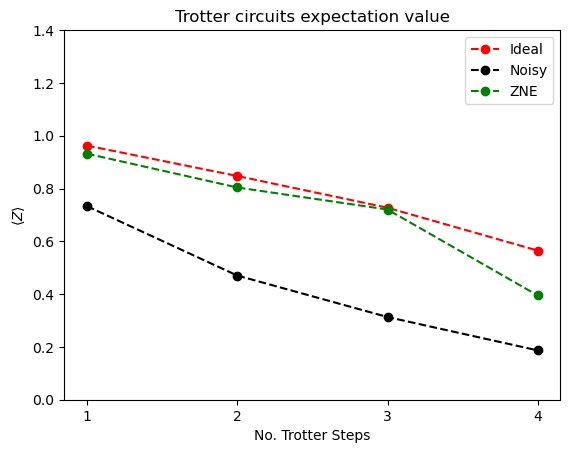

In [17]:
plt.title('Trotter circuits expectation value')
plt.plot(range(1,trotter_steps+1),exact_expvals,'o--', c='red',label='Ideal')
plt.plot(range(1,trotter_steps+1),noisy_expvals,'o--', c='black',label='Noisy')
plt.plot(range(1,trotter_steps+1),zne_expvals,'o--', c='green',label='ZNE')
plt.legend()
plt.ylabel(f"$\langle Z \\rangle$")
plt.xlabel('No. Trotter Steps')
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4])
plt.xticks(range(1,trotter_steps+1))
plt.show()

Plot best extrapolator phase diagram

Text(0, 0.5, 'Number of qubits')

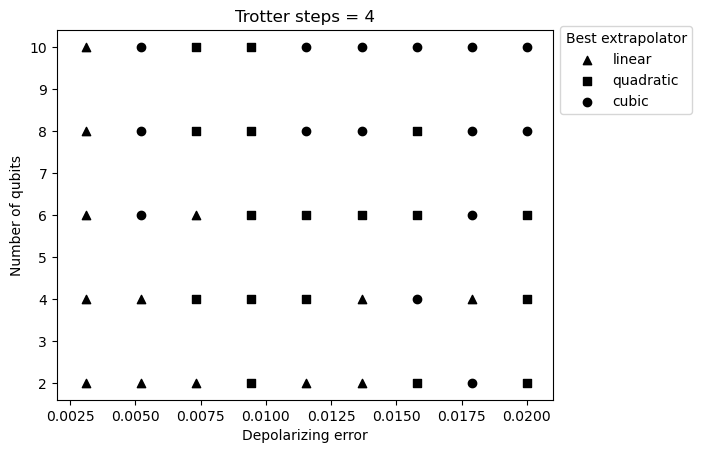

In [20]:
import matplotlib.pyplot as plt

num_steps = 4

marker_dict = {'1': '^',
               '2': 's',
               '3': 'o'}

# Legend
plt.scatter(0.00, 10, marker='^', color='black', label='linear')
plt.scatter(0.00, 10, marker='s', color='black', label='quadratic')
plt.scatter(0.00, 10, marker='o', color='black', label='cubic')
plt.legend(title='Best extrapolator', bbox_to_anchor=(1.0, 1.03))

for i, num_qubit in enumerate(num_qubits):
    for j, err in enumerate(errors):
        plt.scatter(err, num_qubit, marker=marker_dict[str(best_extrapolator[num_qubit][trotter_steps-1][err])], color='black')

plt.xlim(0.002, 0.021)
plt.title('Trotter steps = ' + str(num_steps))
plt.xlabel('Depolarizing error')
plt.ylabel('Number of qubits')

Text(0, 0.5, 'Number of qubits')

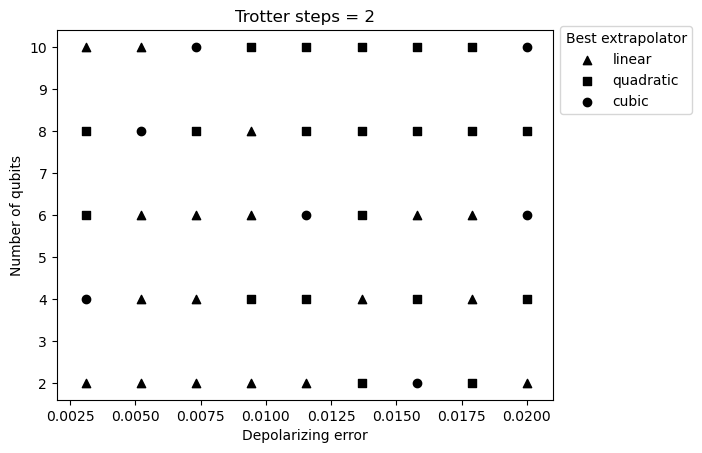

In [21]:
import matplotlib.pyplot as plt

num_steps = 2

marker_dict = {'1': '^',
               '2': 's',
               '3': 'o'}

# Legend
plt.scatter(0.00, 10, marker='^', color='black', label='linear')
plt.scatter(0.00, 10, marker='s', color='black', label='quadratic')
plt.scatter(0.00, 10, marker='o', color='black', label='cubic')
plt.legend(title='Best extrapolator', bbox_to_anchor=(1.0, 1.03))

for i, num_qubit in enumerate(num_qubits):
    for j, err in enumerate(errors):
        plt.scatter(err, num_qubit, marker=marker_dict[str(best_extrapolator[num_qubit][num_steps-1][err])], color='black')

plt.xlim(0.002, 0.021)
plt.title('Trotter steps = ' + str(num_steps))
plt.xlabel('Depolarizing error')
plt.ylabel('Number of qubits')

# Experiment: Twirl circuits to remove coherent error

The goal here is to show that circuits for ZNE should also be twirled to remove coherent error. This way, coherent error does not ``stack" for folded circuits.

To do this experiment, we need a device model with coherent noise on, say, the CX and/or X and/or SX gates.

In [22]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import BackendEstimator

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

import numpy as np
import matplotlib.pyplot as plt

In [28]:
from qiskit_research.utils.convenience import add_pauli_twirls
from qiskit.transpiler.passes import RemoveBarriers

BASIS_GATES = ["sx", "rz", "rzx", "cx"]

def twirl_circuits(circuits_transpiled: list[QuantumCircuit], 
                   num_twirl_instances: int, 
                   active_qubits: list[int], 
                   backend):
    """
    Twirl transpiled circuits. Importantly, they should not have measurements on them!
    To twirl circuits with CNOT as 2Q gates, we're using Qiskit Research's implementation.
    For some reason, Derek has found that it doesn't perform as well as PEC's implementation.
    But PEC's implementation is broken right now.

    Args:
    circuits_transpiled : List[QuantumCircuit]
        Circuits transpiled into native, with either CNOT or RZX as the 2Q gates
    num_twirl_instances : int
        Number of twirled circuits to return
    active_qubits : List[int]
        List of qubits whose gates we will twirl
    backend : backend
        Backend circuits are transpiled to. We shouldn't actually need the backend, but the PEC code we stripped just uses it

    Returns:
    circuits_twirled : List[QuantumCircuit]
        Twirled circuits with the following order: [num_twirl_instances of circuits_transpiled[0], ...]
    """
    circuits_twirled = []
    for i, circ in enumerate(circuits_transpiled):
        circ_twirled = add_pauli_twirls(circ, num_twirled_circuits=num_twirl_instances, transpile_added_paulis = True)
        for c in circ_twirled:
            c = RemoveBarriers()(c)
            circuits_twirled.append(c)

    return circuits_twirled

from qiskit_aer.noise import coherent_unitary_error
from qiskit import QuantumCircuit
import numpy as np

def create_coherent_depol_backend(coherent_error: float, depol_error: float):
    """Returns a noisy simulator backend with coherent error on Rz gates and depolarizing error
    This doesn't actually make sense in practice since Rz gates done in practice,
    but we're doing this for now since the Trotter circuit only has Rz and CX gates

    Args:
        coherent_error (float): Between 0 and 1. #0.01

    Returns:
        backend: A noisy simulator with coherent ZZ error
    """
    # Create the coherent error channel on 2Q gates
    # Copy-pasted from `test_ampcal1Q` in https://programtalk.com/python-more-examples/qiskit.providers.aer.noise.NoiseModel/
    err_unitary = np.zeros([2, 2], dtype=complex)
    for i in range(2):
        err_unitary[i, i] = np.cos(coherent_error)
        err_unitary[i, (i+1) % 2] = np.sin(coherent_error)
    err_unitary[0, 1] *= -1.0
    err_coherent = coherent_unitary_error(err_unitary).tensor(coherent_unitary_error(err_unitary))

    # We want more physical error model here, over-rotation on the target in CNOT. And do some test before doing it.



    # Create the depolarizing error channel
    err_depol = depolarizing_error(depol_error, 2) # error only on CNOT gates


    
    # Create a noise model from the error channels
    noisemodel = NoiseModel()
    err_total = err_coherent.compose(err_depol)
    noisemodel.add_all_qubit_quantum_error(err_total, ['cx'])
    
    err_single = coherent_unitary_error(err_unitary)
    noisemodel.add_all_qubit_quantum_error(err_single, ['rx'])
    
    backend = AerSimulator(noise_model=noisemodel)
    
    return backend

def create_depol_backend_derek(depol_error: float):
    """Returns a noisy simulator backend with coherent error on Rz gates and depolarizing error
    This doesn't actually make sense in practice since Rz gates done in practice,
    but we're doing this for now since the Trotter circuit only has Rz and CX gates

    Args:
        coherent_error (float): Between 0 and 1.

    Returns:
        backend: A noisy simulator with coherent ZZ error
    """
    # Create the depolarizing error channel
    err_depol = depolarizing_error(depol_error, 2) # error only on CNOT gates

    # Create a noise model from the error channels
    noisemodel = NoiseModel()
    noisemodel.add_all_qubit_quantum_error(err_depol, ['cx'])
    
    backend = AerSimulator(noise_model=noisemodel)
    
    return backend

In [26]:
def create_trotter_circuit(num_qubits: int, params: list, trotter_steps: int):
    # creates a particular type of trotter circuit
    # params[0] is for Rx, params[1] is for Rz -> for now same for each layer
    
    trotter_layer = QuantumCircuit(num_qubits)
    trotter_layer.rx(params[0], range(num_qubits))
    
    # a single trotter layer
    for i in range(0,num_qubits,2):
        trotter_layer.cx(i,i+1)
        trotter_layer.rz(params[1], i+1)
        trotter_layer.cx(i,i+1)
    
    for i in range(1,num_qubits-1,2):
        trotter_layer.cx(i,i+1)
        trotter_layer.rz(params[1], i+1)
        trotter_layer.cx(i,i+1)
    
    # full trotter circuit
    trotter_circuit = QuantumCircuit(num_qubits)
    for i in range(trotter_steps):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    
    return trotter_circuit

def get_zne_expval(circ, obs: str, extrapolator, backend, noise_factors = [1,3,5,7], amplifier=LocalFoldingAmplifier(gates_to_fold=2), shots:int=2000) -> float:
    observable = SparsePauliOp(obs)
    
    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)
    
    zne_strategy = ZNEStrategy(
        noise_factors=noise_factors, 
        noise_amplifier=amplifier,
        extrapolator=extrapolator
    )
    
    job = estimator.run(circ, observable, shots=shots, zne_strategy=zne_strategy)
    result = job.result()
    
    return result

def get_expval(circ, obs: str, shots:int=2000, backend=AerSimulator()):
    observable = SparsePauliOp(obs)
    estimator = BackendEstimator(backend=backend)
    
    job = estimator.run(circ, observable, shots=shots)
    result = job.result()
    
    return result

def get_twirled_zne_expval(circ_list, obs: str, extrapolator, backend, noise_factors = [1,3,5,7], amplifier=LocalFoldingAmplifier(gates_to_fold=2), shots:int=2000) -> float:
    """
    Get ZNE expectation value for a list of twirled circuits
    The current implementation is quite inefficient, since we just average the expectation values of the twirled circuits
    Instead, we should probably get the counts for the twirled circuits, merge them together, and then compute expectation values
    Because of this ugly implementation, instead of returning a result, this function returns the zero-noise expectation value
    """
    zero_noise_exp = 0
    for circ in circ_list:
        zero_noise_exp += get_zne_expval(circ, obs, extrapolator, backend, noise_factors, amplifier, int(shots/len(circ_list))).values[0]
    zero_noise_exp = zero_noise_exp / len(circ_list)
    
    return zero_noise_exp

In [40]:
# Inputs
nqubits = 6
obs = 'Z'*nqubits
coherent_error = 0.05
depol_error = 0.01
params = [0.1,0.2]
degree = 1 # 1 for linear, 2 for quadratic, 3 for cubic
degree_dict = {'1': 'linear', '2': 'quadratic', '3': 'cubic'}
noise_factors = [1, 3, 5]
num_twirl_instances = 40
trotter_steps = 10

extrapolator = PolynomialExtrapolator(degree=degree)
backend = create_coherent_depol_backend(coherent_error, depol_error)
backend_depol = create_depol_backend_derek(depol_error)


exact_expvals = []
noisy_expvals = []
zne_expvals = []
twirled_zne_expvals = []
twirled_zne_expvals_no_coherent_error = []
for trot_step in range(1,trotter_steps+1):
    print('trotter step: ', str(trot_step))
    trot_circ = create_trotter_circuit(nqubits,params,trot_step)
    exact_expvals.append(get_expval(trot_circ, obs).values[0])
    
    noisy_expvals.append(get_expval(trot_circ, obs, backend=backend).values[0])
    
    twirled_trot_circs = twirl_circuits([trot_circ], num_twirl_instances=num_twirl_instances, active_qubits=range(nqubits), backend=backend)
    zne_expvals.append(get_zne_expval(trot_circ, obs, extrapolator, backend, noise_factors=noise_factors).values[0])
    twirled_zne_expvals.append(get_twirled_zne_expval(twirled_trot_circs, obs, extrapolator, backend, noise_factors=noise_factors))
    twirled_zne_expvals_no_coherent_error.append(get_twirled_zne_expval(twirled_trot_circs, obs, extrapolator, backend_depol, noise_factors=noise_factors))

trotter step:  1
trotter step:  2
trotter step:  3
trotter step:  4
trotter step:  5
trotter step:  6
trotter step:  7
trotter step:  8
trotter step:  9
trotter step:  10


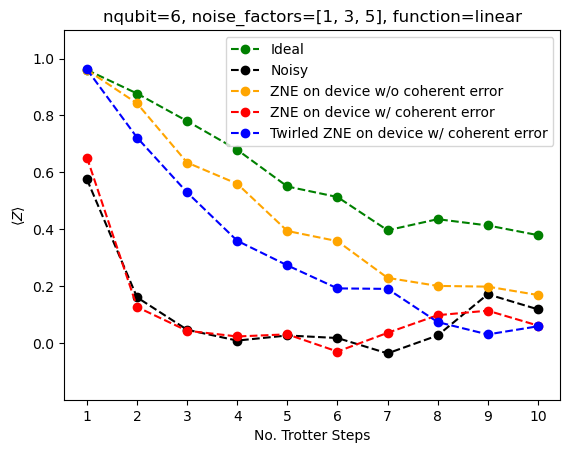

In [41]:
plt.plot(range(1,trotter_steps+1),exact_expvals,'o--', c='green',label='Ideal')
plt.plot(range(1,trotter_steps+1),noisy_expvals,'o--', c='black',label='Noisy')
plt.plot(range(1,trotter_steps+1),twirled_zne_expvals_no_coherent_error,'o--', c='orange',label='ZNE on device w/o coherent error')
plt.plot(range(1,trotter_steps+1),zne_expvals,'o--', c='red',label='ZNE on device w/ coherent error')
plt.plot(range(1,trotter_steps+1),twirled_zne_expvals,'o--', c='blue',label='Twirled ZNE on device w/ coherent error')

plt.ylim([-0.2, 1.1])
plt.ylabel(f"$\langle Z \\rangle$")
plt.xlabel('No. Trotter Steps')
plt.title('nqubit=' + str(nqubits) + ', noise_factors=' + str(noise_factors) + ', function=' + degree_dict[str(degree)])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(range(1,trotter_steps+1))
plt.legend()
plt.show()

# Experiment: Mitigate readout error

The goal here is to show that readout error can and should be separately mitigated. This may seen obvious to us since we very often use error mitigation, but to many users new to the field, they are often unaware that ZNE does not cancel readout error or that they have to separately indicate this option.

This experiment should be simple. We just need to show that readout error means even depth 0 circuits with ZNE will not have ideal results and that the effect of readout error is depth-independent. So for a set of Clifford circuits, we just need to mitigate errors with ZNE with a noise model that does or does not contain readout error. 

In the future, we need to run this on hardware, so we will have to develop a way of doing ZNE with `mthree` and `TREx`.

In [42]:
import qiskit
from qiskit import QuantumCircuit
from qiskit.compiler import transpile
from qiskit_aer import AerSimulator
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_aer.noise import depolarizing_error, coherent_unitary_error, NoiseModel, ReadoutError
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives import BackendEstimator

from zne import zne, ZNEStrategy
from zne.noise_amplification import *
from zne.extrapolation import *

import numpy as np
import matplotlib.pyplot as plt

In [43]:
from qiskit_research.utils.convenience import add_pauli_twirls
from qiskit.transpiler.passes import RemoveBarriers

BASIS_GATES = ["sx", "rz", "rzx", "cx"]

def twirl_circuits(circuits_transpiled: list[QuantumCircuit], 
                   num_twirl_instances: int, 
                   active_qubits: list[int], 
                   backend):
    """
    Twirl transpiled circuits. Importantly, they should not have measurements on them!
    To twirl circuits with CNOT as 2Q gates, we're using Qiskit Research's implementation.
    For some reason, Derek has found that it doesn't perform as well as PEC's implementation.
    But PEC's implementation is broken right now.

    Args:
    circuits_transpiled : List[QuantumCircuit]
        Circuits transpiled into native, with either CNOT or RZX as the 2Q gates
    num_twirl_instances : int
        Number of twirled circuits to return
    active_qubits : List[int]
        List of qubits whose gates we will twirl
    backend : backend
        Backend circuits are transpiled to. We shouldn't actually need the backend, but the PEC code we stripped just uses it

    Returns:
    circuits_twirled : List[QuantumCircuit]
        Twirled circuits with the following order: [num_twirl_instances of circuits_transpiled[0], ...]
    """
    circuits_twirled = []
    for i, circ in enumerate(circuits_transpiled):
        circ_twirled = add_pauli_twirls(circ, num_twirled_circuits=num_twirl_instances, transpile_added_paulis = True)
        for c in circ_twirled:
            c = RemoveBarriers()(c)
            circuits_twirled.append(c)

    return circuits_twirled

from qiskit_aer.noise import coherent_unitary_error
from qiskit import QuantumCircuit
import numpy as np

def create_readout_depol_backend(p0given1, p1given0, nqubits, depol_error):
    """Returns a noisy simulator backend with readout error

    Args:
        p0given1 (float): Probability of measuring 0 when 1 is the correct result. Between 0 and 1.
        p1given0 (float): Probability of measuring 1 when 0 is the correct result. Between 0 and 1.

    Returns:
        backend: A noisy simulator with readout error
    """
    # Create the readout error channel on 2Q gates
    # Copy-pasted from https://qiskit.org/documentation/tutorials/simulators/3_building_noise_models.html
    err_ro = ReadoutError([[1 - p1given0, p1given0], [p0given1, 1 - p0given1]])

     # Create the depolarizing error channel
    err_depol = depolarizing_error(depol_error, 2) # error only on CNOT gates

    # Create a noise model from the error channels
    noisemodel = NoiseModel()
    noisemodel.add_all_qubit_quantum_error(err_depol, ['cx'])
    for i in range(nqubits):
        noisemodel.add_readout_error(err_ro, [i])
    
    backend = AerSimulator(noise_model=noisemodel)
    
    return backend

def create_depol_backend_derek(depol_error: float):
    """Returns a noisy simulator backend with coherent error on Rz gates and depolarizing error
    This doesn't actually make sense in practice since Rz gates done in practice,
    but we're doing this for now since the Trotter circuit only has Rz and CX gates

    Args:
        coherent_error (float): Between 0 and 1.

    Returns:
        backend: A noisy simulator with coherent ZZ error
    """
    # Create the depolarizing error channel
    err_depol = depolarizing_error(depol_error, 2) # error only on CNOT gates

    # Create a noise model from the error channels
    noisemodel = NoiseModel()
    noisemodel.add_all_qubit_quantum_error(err_depol, ['cx'])
    
    backend = AerSimulator(noise_model=noisemodel)
    
    return backend

In [44]:
def create_trotter_circuit(num_qubits: int, params: list, trotter_steps: int):
    # creates a particular type of trotter circuit
    # params[0] is for Rx, params[1] is for Rz -> for now same for each layer
    
    trotter_layer = QuantumCircuit(num_qubits)
    trotter_layer.rx(params[0], range(num_qubits))
    
    # a single trotter layer
    for i in range(0,num_qubits,2):
        trotter_layer.cx(i,i+1)
        trotter_layer.rz(params[1], i+1)
        trotter_layer.cx(i,i+1)
    
    for i in range(1,num_qubits-1,2):
        trotter_layer.cx(i,i+1)
        trotter_layer.rz(params[1], i+1)
        trotter_layer.cx(i,i+1)
    
    # full trotter circuit
    trotter_circuit = QuantumCircuit(num_qubits)
    for i in range(trotter_steps):
        trotter_circuit = trotter_circuit.compose(trotter_layer)
    
    return trotter_circuit

def get_zne_expval(circ, obs: str, extrapolator, backend, noise_factors = [1,3,5,7], amplifier=LocalFoldingAmplifier(gates_to_fold=2), shots:int=2000) -> float:
    observable = SparsePauliOp(obs)
    
    ZNEEstimator = zne(BackendEstimator)
    estimator = ZNEEstimator(backend=backend)
    
    zne_strategy = ZNEStrategy(
        noise_factors=noise_factors, 
        noise_amplifier=amplifier,
        extrapolator=extrapolator
    )
    
    job = estimator.run(circ, observable, shots=shots, zne_strategy=zne_strategy)
    result = job.result()
    
    return result

def get_expval(circ, obs: str, shots:int=2000, backend=AerSimulator()):
    observable = SparsePauliOp(obs)
    estimator = BackendEstimator(backend=backend)
    
    job = estimator.run(circ, observable, shots=shots)
    result = job.result()
    
    return result

def get_twirled_zne_expval(circ_list, obs: str, extrapolator, backend, noise_factors = [1,3,5,7], amplifier=LocalFoldingAmplifier(gates_to_fold=2), shots:int=2000) -> float:
    """
    Get ZNE expectation value for a list of twirled circuits
    The current implementation is quite inefficient, since we just average the expectation values of the twirled circuits
    Instead, we should probably get the counts for the twirled circuits, merge them together, and then compute expectation values
    Because of this ugly implementation, instead of returning a result, this function returns the zero-noise expectation value
    """
    zero_noise_exp = 0
    for circ in circ_list:
        zero_noise_exp += get_zne_expval(circ, obs, extrapolator, backend, noise_factors, amplifier, int(shots/len(circ_list))).values[0]
    zero_noise_exp = zero_noise_exp / len(circ_list)
    
    return zero_noise_exp

In [45]:
# Inputs
nqubits = 6
obs = 'Z'*nqubits
p0given1 = 0.05
p1given0 = 0.02
depol_error = 0.01
params = [0.1,0.2]
degree = 1 # 1 for linear, 2 for quadratic, 3 for cubic
degree_dict = {'1': 'linear', '2': 'quadratic', '3': 'cubic'}
noise_factors = [1, 3, 5]
trotter_steps = 10

extrapolator = PolynomialExtrapolator(degree=degree)
backend_ro_depol = create_readout_depol_backend(p0given1, p1given0, nqubits, depol_error)
backend_depol = create_depol_backend_derek(depol_error)


exact_expvals = []
noisy_ro_expvals = []
zne_expvals_with_readout_error = []
zne_expvals_without_readout_error = []
for trot_step in range(1,trotter_steps+1):
    print('trotter step: ', str(trot_step))
    trot_circ = create_trotter_circuit(nqubits,params,trot_step)
    exact_expvals.append(get_expval(trot_circ, obs).values[0])
    
    noisy_ro_expvals.append(get_expval(trot_circ, obs, backend=backend_ro_depol).values[0])
    
    zne_expvals_with_readout_error.append(get_zne_expval(trot_circ, obs, extrapolator, backend_ro_depol, noise_factors=noise_factors).values[0])
    zne_expvals_without_readout_error.append(get_zne_expval(trot_circ, obs, extrapolator, backend_depol, noise_factors=noise_factors).values[0])

trotter step:  1
trotter step:  2
trotter step:  3
trotter step:  4
trotter step:  5
trotter step:  6
trotter step:  7
trotter step:  8
trotter step:  9
trotter step:  10


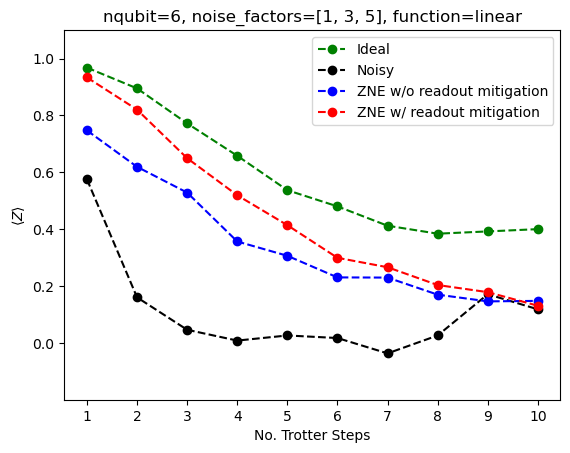

In [46]:
plt.plot(range(1,trotter_steps+1),exact_expvals,'o--', c='green',label='Ideal')
plt.plot(range(1,trotter_steps+1),noisy_expvals,'o--', c='black',label='Noisy')
plt.plot(range(1,trotter_steps+1),zne_expvals_with_readout_error,'o--', c='blue',label='ZNE w/o readout mitigation')
plt.plot(range(1,trotter_steps+1),zne_expvals_without_readout_error,'o--', c='red',label='ZNE w/ readout mitigation')
plt.ylim([-0.2, 1.1])
plt.ylabel(f"$\langle Z \\rangle$")
plt.xlabel('No. Trotter Steps')
plt.title('nqubit=' + str(nqubits) + ', noise_factors=' + str(noise_factors) + ', function=' + degree_dict[str(degree)])
plt.yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
plt.xticks(range(1,trotter_steps+1))
plt.legend()
plt.show()

# Experiment: Folding _after_ decomposition into native gates

# Experiment: Sampling multiple partially folded circuits

